In [10]:
import h5py;
import numpy as np;
import pandas as pd;
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Problem

The aim of this investigation is to find a way how to determine whether the given point of muscle is a cellular space or an interstitial space by spectral images. Let's begin the exploration from the fact that sodium is easily washing away element, so it luminesces mostly from cellular space.

So the simple idea is to make a dataset, which contains coordinate and sodium luminescence intenisty of the given point. And then find optimal parameters for clusterisation algorithm to divide cellular and intersticial clusters accurately.

Of course, this approach is quite simple and depends on good feature engineering (not only coordinates and sodium luminiscence intensity), that is a subject for further discussions

In [11]:
# code numbers of scans
scan_numbers = [7, 9, 16, 24, 27, 30, 43, 48, 52,
                61, 63, 68, 78, 81, 83, 90, 92, 95]

# Useful functions

In [12]:
# getting array from h5 file
def get_array(scan_num):
    scan_code = f'0{scan_num}' if scan_num < 10 else scan_num
    file_path = f'Fitting/scan_{scan_code}/sdd0134567/xrf_flat_scan_{scan_num}_aligned.h5'
    f = h5py.File(file_path, 'r')
    return np.array(f[f'xrf_flat_scan_{scan_num}_aligned']['plotselect']['Na_K'])

In [13]:
# organising data i.e. features from array (x pos, y pos and spectral intensity)
def get_pd_from_array(array):
    data_arr = []
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            data_arr.append([i, j, array[i, j]])
        
    return pd.DataFrame(data=data_arr, columns=['x', 'y', 'Intensity'])

In [14]:
# getting data, scaled data and plotting the scan
def aggregate_data(arr):
    pd_arr = get_pd_from_array(arr)
    pd_arr_scaled = MinMaxScaler().fit_transform(pd_arr)
    plt.pcolormesh(arr, cmap=cm.get_cmap('jet'))
    return pd_arr, pd_arr_scaled

# Finding good parameters of clasterisation for specific scan. For example, scan_24

In [17]:
arr24 = get_array(24)

## Replace nan

In [18]:
np.any(np.isnan(arr24))

True

In [19]:
na_indices = np.argwhere(np.isnan(arr24))
na_indices

array([[ 1, 35],
       [97, 20]], dtype=int64)

In [24]:
def replace_nan_with_neighbours_mean(arr):
    na_indices = np.argwhere(np.isnan(arr))
    for i_j in na_indices:
        i, j = i_j[0], i_j[1] 
        arr[i, j] = (arr[i, j-1]+arr[i, j-1]) / 2;

In [25]:
replace_nan_with_neighbours_mean(arr24)

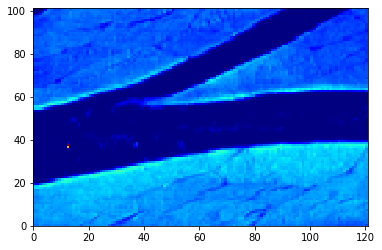

In [26]:
data24, data24_scaled = aggregate_data(arr24)

In [27]:
data24.sort_values(by='Intensity', ascending=False)

,x,y,Intensity
4489,37,12,59192.742188
4368,36,12,42601.000000
3056,25,31,25661.185547
3055,25,30,25466.730469
3306,27,39,24889.357422
...,...,...,...
9877,81,76,91.207268
11587,95,92,90.410210
10853,89,84,86.719002
10736,88,88,78.455849


In [28]:
arr24[37, 12] = (arr24[37, 11] + arr24[37, 13]) / 2

In [29]:
arr24[36, 12] = (arr24[36, 11] + arr24[36, 13]) / 2

## Fixed scan_24

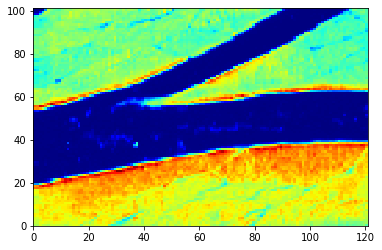

In [37]:
data24, data24_scaled = aggregate_data(arr24)

## Dummy

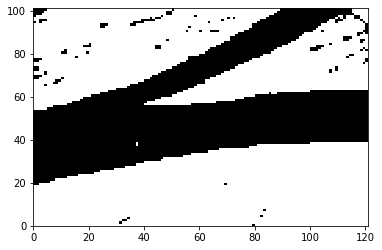

In [31]:
plt.pcolormesh(arr24 < arr24.mean(), cmap=cm.get_cmap('Greys'))

## Agglomerative clustering

In [32]:
agg_clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

In [33]:
const = 10

data24_scaled_ = data24_scaled.copy()
data24_scaled_[:, 2] *= const

In [34]:
clusters24 = agg_clustering.fit(data24_scaled_)

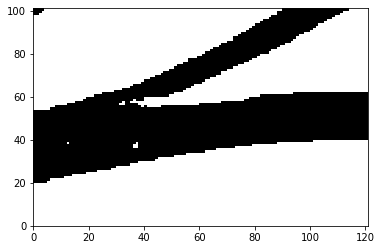

In [35]:
new_map = clusters24.labels_.reshape(arr24.shape)
plt.pcolormesh(new_map, cmap=cm.get_cmap('Greys'))

In [943]:
# 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'
# 'ward', 'complete', 'average', 'single'

## DBSCAN

In [986]:
eps = 0.1
perc = 0.1 # part of points in epsilon area, which we will treat as min_samples to be considered as a core point

min_samples = int(perc * np.pi*(eps * max(arr24.shape))**2)
params24 = {'eps': eps, 'min_samples': min_samples}

In [987]:
min_samples

45

In [988]:
dbscan = DBSCAN(**params24)
clustering24 = dbscan.fit(data24_scaled)

In [989]:
clustering24.labels_

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

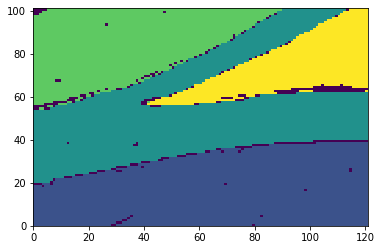

In [990]:
plt.pcolormesh(clustering24.labels_.reshape(101, 121),
               cmap=cm.get_cmap('viridis'))

**We can turn it into binary clusterisation choosing threshold judging by cluster average intenisty**

In [991]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3], dtype=int64)

In [992]:
data24_clust = pd.DataFrame(data24_scaled, columns=['x', 'y', 'I'])

In [993]:
data24_clust['clust'] = clustering24.labels_

In [994]:
data24_clust

,x,y,I,clust
0,0.0,0.000000,0.549032,0
1,0.0,0.008333,0.554709,0
2,0.0,0.016667,0.612895,0
3,0.0,0.025000,0.574224,0
4,0.0,0.033333,0.568090,0
...,...,...,...,...
12216,1.0,0.966667,0.484715,3
12217,1.0,0.975000,0.452044,3
12218,1.0,0.983333,0.457682,3
12219,1.0,0.991667,0.491195,3


In [995]:
average_I = {}

for label in np.unique(clustering.labels_):
    av_I_label = data24_clust[data24_clust.clust == label].I.mean()
    average_I[label] = av_I_label

In [996]:
average_I

{-1: 0.45946780677949645,
 0: 0.6672191343216148,
 1: 0.01575743872505357,
 2: 0.49282564512862453,
 3: 0.5002208680193466}

In [997]:
threshold = average_I[-1]
data24_clust['bin'] = [int(average_I[label] > threshold) for label in data24_clust.clust]

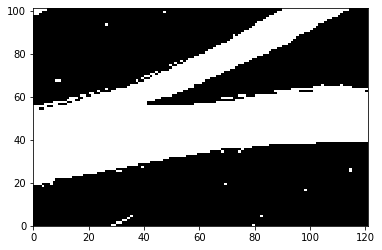

In [998]:
plt.pcolormesh(data24_clust['bin'].values.reshape(101, 121), cmap=cm.get_cmap('Greys'))

# New data

# scan_16

In [999]:
arr16 = get_array(16)

In [1000]:
np.any(np.isnan(arr16))

False

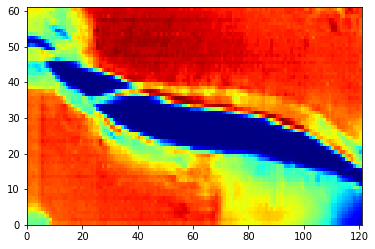

In [1001]:
data16, data16_scaled = aggregate_data(arr16)

In [1002]:
arr16.shape

(61, 121)

## Dummy

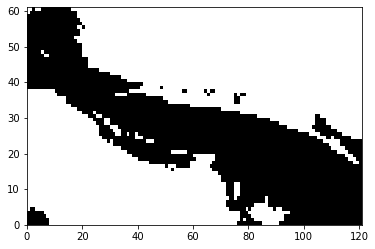

In [1057]:
plt.pcolormesh(arr16 < arr16.mean(), cmap=cm.get_cmap('Greys'))

## Agglomerative clustering

In [1081]:
data16_scaled_ = data16_scaled.copy()
data16_scaled_[:, 2] *= const

In [1082]:
clusters16 = agg_clustering.fit(data16_scaled_)

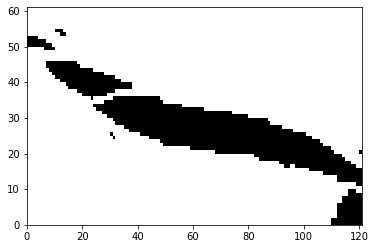

In [1083]:
plt.pcolormesh(clusters16.labels_.reshape(61, 121), cmap=cm.get_cmap('Greys'))

## DBSCAN

In [1138]:
min_samples16 = int(perc * np.pi*(eps * max(arr16.shape))**2)
params16 = {'eps': eps, 'min_samples': min_samples16}

In [1139]:
clustering16 = DBSCAN(**params16).fit(data16_scaled)

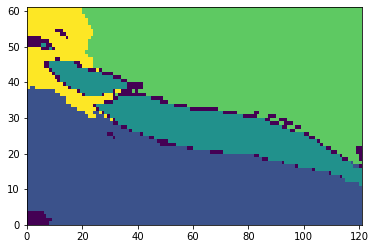

In [1140]:
plt.pcolormesh(clustering16.labels_.reshape(61, 121),
               cmap=cm.get_cmap('viridis'))

# scan 7

In [1009]:
arr7 = get_array(7)

In [1010]:
arr7.shape

(111, 121)

In [1011]:
np.any(np.isnan(arr7))

False

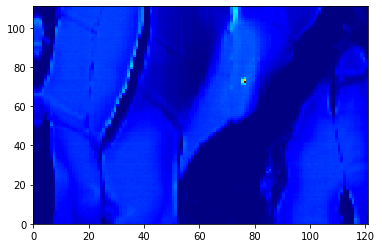

In [1019]:
data7, data7_scaled = aggregate_data(arr7)

In [1020]:
data7.sort_values(by='Intensity', ascending=False)[:10]

,x,y,Intensity
8788,72,76,126873.656250
8909,73,76,87272.093750
8787,72,75,56463.394531
8908,73,75,52010.695312
12777,105,72,45701.597656
12656,104,72,45601.058594
13140,108,72,45278.992188
13141,108,73,44943.519531
12898,106,72,44731.503906
13020,107,73,44225.511719


In [1028]:
arr7[72, 76] = 58000
arr7[73, 76] = 58000
arr7[72, 75] = 58000
arr7[73, 75] = 58000

## Fixed scan_7

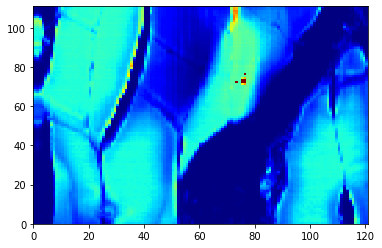

In [1034]:
data7, data7_scaled = aggregate_data(arr7)

## Dummy

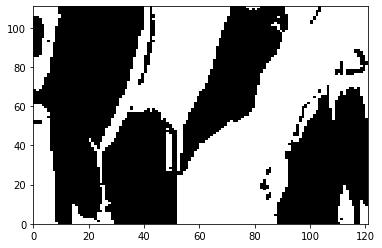

In [1088]:
plt.pcolormesh(arr7 > arr7.mean(), cmap=cm.get_cmap('Greys'))

## Agglomerative clustering

In [1085]:
data7_scaled_ = data7_scaled.copy()
data7_scaled_[:, 2] *= const

In [1086]:
clusters7 = agg_clustering.fit(data7_scaled_)

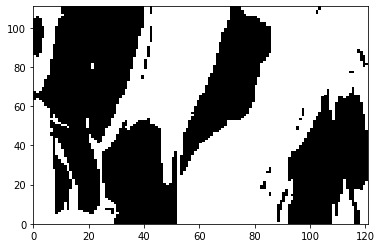

In [1087]:
plt.pcolormesh(clusters7.labels_.reshape(111, 121), cmap=cm.get_cmap('Greys'))

## DBSCAN

In [1144]:
min_samples7 = int(perc * np.pi*(eps * max(arr7.shape))**2)
params7 = {'eps': eps, 'min_samples': min_samples7}

In [1145]:
min_samples7

45

In [1146]:
clustering7 = DBSCAN(**params7).fit(data7_scaled)

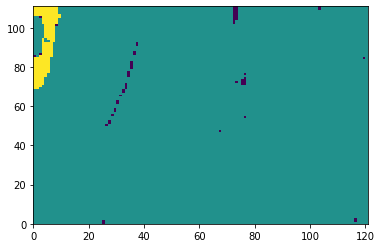

In [1147]:
plt.pcolormesh(clustering7.labels_.reshape(111, 121),
               cmap=cm.get_cmap('viridis'))

# scan 9

In [1094]:
arr9 = get_array(9)

In [1095]:
arr9.shape

(56, 61)

In [1096]:
np.any(np.isnan(arr9))

False

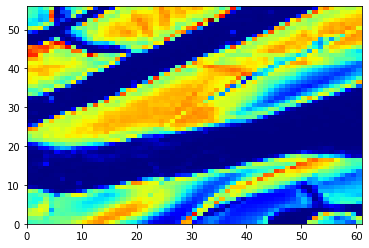

In [1046]:
data9, data9_scaled = aggregate_data(arr9)

# Dummy

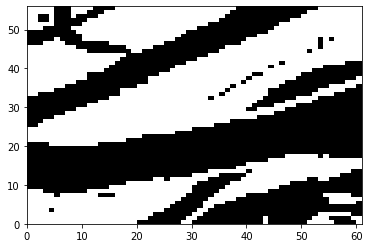

In [1077]:
plt.pcolormesh(arr9 < arr9.mean(), cmap=cm.get_cmap('Greys'))

## Agglomerative clustering

In [1152]:
data9_scaled_ = data9_scaled.copy()
data9_scaled_[:, 2] *= const/4

In [1153]:
clusters9 = agg_clustering.fit(data9_scaled_)

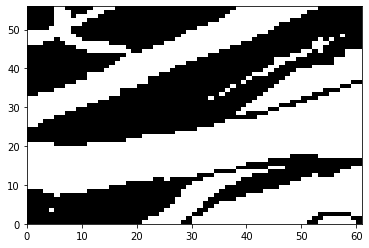

In [1154]:
plt.pcolormesh(clusters9.labels_.reshape(56, 61), cmap=cm.get_cmap('Greys'))

## DBSCAN

In [1155]:
min_samples9 = int(0.2 * np.pi*(eps * max(arr9.shape))**2)
params9 = {'eps': eps, 'min_samples': min_samples9}

In [1156]:
clustering9 = DBSCAN(**params9).fit(data9_scaled)

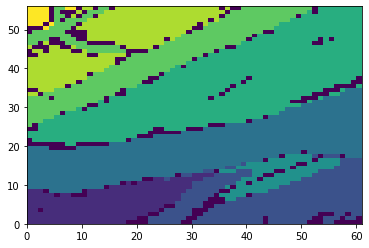

In [1157]:
plt.pcolormesh(clustering9.labels_.reshape(56, 61),
               cmap=cm.get_cmap('viridis'))